## Part 1

In [1]:
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In this part we want to define 'custom CNN compiler', which would be able to easily construct the trainable CNN architecture from the dictionary of given hyperparameter values. Note that for this assignment we'll be doing our experiments on Digits dataset, from the previous exercise. For the given assignment we can build a CNN from the following 'parts':

- Number of filters for the convolution - an integer chosen from the set {8, 16, 32}.


- Kernel size for the convolution. One dimension of the kernel size is the only sufficient input, since the kernels are alway square in our case. Moreover, it dictates the padding, and the stride is always set to 1. Kernel size is an integer chosen from the set {3,5}.
  
  If kernel size is set to **3**, then we have a configuration of
  - *kernel=(3,3), stride=1, padding=1;*
  
  else, if the kernel size is set to **5**, then we have a configuration of
  - *kernel=(5,5), stride=1, padding=2.*


- Activation function is a string chosen from the set {'relu', 'sigmoid', 'tanh', 'softplus', 'elu'}, each string representing the corresponding function.


- Pooling type is a string chosen from the set {'identity', 'avg', 'max'}.
  - If 'avg' or 'max' is selected, then the size of the pooling window will be 2x2;
  - else, if 'identity' is selected, then no pooling will be performed.


- Number of neurons in a Linear1 layer is an integer chosen from the set {10, 20, ... ,100}.


- Number of classes is determined by the dataset we wish to train our CNN on (which is equal to 10, in this case).

In [2]:
#some helper modules
# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
  
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [3]:
#this is our Custom CNN constructer; given the selection of hyperparameters it constructs a corresponding
#CNN architecture, ready for train and evaluation on the Digits dataset
class CustomCNN():
    
    def __init__(self, num_filters, kernel_size, activation_func, pooling_type, mlp_neurons_num, num_classes=10):
        self.mlp_neurons_num = mlp_neurons_num
        self.num_classes = num_classes
        
        self.reshape = Reshape(size=(1,8,8))
        
        self.flatten = Flatten()
        
        self.conv = nn.Conv2d(in_channels=1,
                            out_channels=num_filters,
                            kernel_size=kernel_size,
                            stride=1,
                            padding=1 if kernel_size==3 else 2)
        
        activations = {'relu':nn.ReLU(),
                       'sigmoid':nn.Sigmoid(),
                       'tanh':nn.Tanh(),
                       'softplus':nn.Softplus(),
                       'elu':nn.ELU()}
        self.activation = activations[activation_func]
        
        
        poolings = {'identity':nn.Identity(),
                   'avg':nn.AvgPool2d(kernel_size=2),
                   'max':nn.MaxPool2d(kernel_size=2)}
        self.pooling = poolings[pooling_type]
        
        
        
    def compile_cnn(self):
        return nn.Sequential(self.reshape,
                            self.conv,
                            self.activation,
                            self.pooling,
                            self.flatten,
                            nn.LazyLinear(out_features=self.mlp_neurons_num),
                            self.activation,
                            nn.LazyLinear(out_features=self.num_classes),
                            nn.Softmax(dim=1))

Now we test our CustomCNN class, to see if it will construct a CNN architecture for a given sample set of hyperparameters, and if it will forward pass a random input tensor, outputing the proper shape (batch_size x num_classes), (64x10 in our case).

In [4]:
hyperparameters = {'num_filters':8, 
                  'kernel_size':3,
                  'activation_func':'relu',
                  'pooling_type':'avg',
                  'mlp_neurons_num':10}

In [5]:
SampleCNN = CustomCNN(**hyperparameters).compile_cnn()

In [6]:
print(SampleCNN)

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Flatten()
  (5): LazyLinear(in_features=0, out_features=10, bias=True)
  (6): ReLU()
  (7): LazyLinear(in_features=0, out_features=10, bias=True)
  (8): Softmax(dim=1)
)


In [7]:
sample_output = SampleCNN(torch.randn(64, 64))
sample_output.shape

torch.Size([64, 10])

## Part 2

Now that we saw that our Custom CNN Compiler does it's job, we load the Digits dataset and prepare it for training, validation and testing.

In [8]:
import os

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader

In [9]:
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

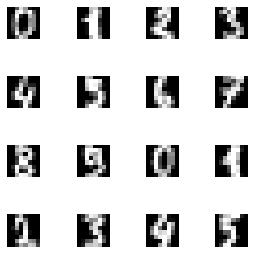

In [10]:
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4,4,figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4*i+j],(8,8))
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].axis('off')

## Part 3

In this part we will use the ClassifierNeuralNet class, along with the train and evaluate function from the previous exercise, modify them to be used with our Custom CNN builder and for neuroevolution (i.e. genetic algorithms).


### Part 3.1

Here we just import the ClassifierNeuralNet form the previous exercise - with a small change: in this case we'll be using CrossEntropyLoss instead of NLLLoss (since in this case we are receiving the softmax as an input, not the log-softmax!)

In [11]:
# Implementing a neural network (NN) classifier. 
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function
        self.cross_e = nn.CrossEntropyLoss(reduction='none')#it requires softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        #using the sofrmax outputs of our network, we first compute the probability
        #values for each class
        y_logit = self.classnet(x)
        #then we select the class with the highest probability values
        y_pred = torch.argmax(y_logit, dim=1).type(torch.long)
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        #here the loss function compares the softmax output values of the neural net
        #prediction with ground-truth labels which is a 0-1 vector, with the only 1 in the
        #place of the corresponding label
        loss = self.cross_e(self.classnet(x), y.type(torch.long))
        #using the reduction we either sum the loss over the batch, or find the mean value
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

### Part 3.2

Here we use the evaluation function from the previous exercise, with some modifications regarding the neuroevolution.

When evaluating on the validation set during the neuroevolution process, we use an updated classification error function, which we look to minimize:

Objective = ClassError + $0.01\frac{N_p}{N_\max},$

where $N_p$ is the number of weights of the current model, and $N_\max$ is a number of weights of the largest possible NN in the search space. 

In our case we estimate $N_\max$ to be for the configuration

    biggest_cnn = {'num_filters':32, 
              'kernel_size':5,
              'activation_func':anything,
              'pooling_type':'identity',
              'mlp_neurons_num':100}
              

totalling 206 742 trainable weights (and biases): 832 from convolution, 204 900 for Linear 1, and 1 010 for Linear 2.

In [12]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, neuroevolution=False):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + '.model')

    model_best.eval()# set the model to the evaluation mode
    loss_test = 0.
    loss_error = 0.
    N = 0.
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        if neuroevolution:
            num_weights = sum(p.numel() for p in model_best.parameters() if p.requires_grad)
            largest_net_weights = 206742
            loss_error += .01*(num_weights/largest_net_weights)
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

# Print the performance
    if epoch is None:
        print(f'-> FINAL PERFORMANCE: cross_e={loss_test}, ce={loss_error}')
    else:
        if epoch % 10 == 0 and not neuroevolution:
            print(f'Epoch: {epoch}, val cross_e={loss_test}, val ce={loss_error}')

    return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='cross_e', color='b-', test_eval=None):
    # plot the curve
    plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel +' test')
        plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
        # set x- and ylabels, add legend, save the figure
        plt.xlabel(xlabel), plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(name + file_name, bbox_inches='tight')
        plt.show()

### Part 3.3

Here we include and modify the training function from the previous exercise to be used in neuroevolution. Since during the neuroevolution we'll be training a bunch of custom CNNs for only 10 epochs, we won't be saving the models, and won't be using the patience parameter. In this case we're interested only in the lowest classification error on the validation set, which will be compared to other custom CNN architecutres in the population pool, in a search for best-performing configuration.

In [13]:
# The training procedure
def training(name, num_epochs, model, optimizer, training_loader, val_loader, max_patience=None, neuroevolution=False):
    cross_e_val = []
    error_val = []
    best_cross_e = 1000.
    patience = 0
    
  # Main training loop
    for e in range(num_epochs+1):
        model.train() # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
          # calculate the forward pass (loss function for given images and labels)
          loss = model.forward(batch, targets)
          # remember we need to zero gradients! Just in case!
          optimizer.zero_grad()
          # calculate backward pass
          loss.backward(retain_graph=True)
          # run the optimizer
          optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e, neuroevolution=neuroevolution)
        cross_e_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        
        if not neuroevolution:
            # Early-stopping: update the best performing model and break training if no 
            # progress is observed.
            if e == 0:
                torch.save(model, name + '.model')
                best_nll = loss_e
            else:
                if loss_e < best_nll:
                    torch.save(model, name + '.model')
                    best_nll = loss_e
                    patience = 0
                else:
                    patience = patience + 1
        
            if patience > max_patience:
                break

  
    if not neuroevolution:
        # Return CrossEntropy and classification error
        cross_e_val = np.asarray(cross_e_val)
        error_val = np.asarray(error_val)
        return cross_e_val, error_val
    else:
        return np.min(error_val)

### Part 3.4

Here we just initialize train. val. and test sets, and the corresponding Data Loaders.

In [18]:
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Part 3.5

In this part we combine our Custom CNN constructor, with some code from the previous exercise for running the full training and evaluation procedure for the given architecture. Here we propose a sample set of hyperparameters, to check if our Custom CNN constructor is compatible with the given training and evaluation procedures, i.e. can we get a fully-trained and validated CNN just by providing a dictionary of hyperparameters.

In [19]:
#Initialize sample CNN architecture hyperparameters
sample_hyperparameters = {'num_filters':8, 
                          'kernel_size':3,
                          'activation_func':'relu',
                          'pooling_type':'avg',
                          'mlp_neurons_num':10}

In [20]:
def train_and_evaluate_full(hyperparameters, name, num_epochs=1000, max_patience=20):
    
    #Initialize training hpyerparameters
    lr = 1e-3 # learning rate
    wd = 1e-5 # weight decay
    
    # Create a folder if necessary
    results_dir = os.getcwd()
    result_dir = os.path.join(results_dir, 'results', name)
    if not(os.path.exists(result_dir)):
        os.makedirs(result_dir)
        
    # Init ClassifierNN
    classnet = CustomCNN(**hyperparameters).compile_cnn()
    model = ClassifierNeuralNet(classnet)
    
    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd)
    
    # Training procedure
    cross_e_val, error_val = training(name=name,
                                    num_epochs=num_epochs,
                                    model=model,
                                    optimizer=optimizer,
                                    training_loader=training_loader,
                                    max_patience=max_patience,
                                    val_loader=val_loader)

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=name, test_loader=test_loader)
    
    # write the results to a file
    f = open(result_dir + name + '_test_loss.txt', "w")
    f.write('CrossEntropy: ' + str(test_loss) + '\nCE: ' + str(test_error))
    f.close()

    # create curves
    plot_curve(result_dir + name, cross_e_val, file_name='_cross_e_val_curve.pdf', ylabel='cross_e', test_eval=test_loss)
    plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)


Epoch: 0, val cross_e=2.283915579659598, val ce=0.7857142857142857
Epoch: 10, val cross_e=2.053319647652762, val ce=0.48857142857142855
Epoch: 20, val cross_e=1.8691698237827845, val ce=0.3514285714285714
Epoch: 30, val cross_e=1.8067624010358538, val ce=0.3028571428571429
Epoch: 40, val cross_e=1.7374926103864397, val ce=0.24
Epoch: 50, val cross_e=1.6906974138532367, val ce=0.19142857142857142
Epoch: 60, val cross_e=1.671537857055664, val ce=0.18857142857142858
Epoch: 70, val cross_e=1.6607787758963448, val ce=0.1742857142857143
Epoch: 80, val cross_e=1.6492989567347935, val ce=0.16857142857142857
Epoch: 90, val cross_e=1.6468441881452287, val ce=0.17714285714285713
Epoch: 100, val cross_e=1.640567834036691, val ce=0.17142857142857143
Epoch: 110, val cross_e=1.6419567326136997, val ce=0.17714285714285713
Epoch: 120, val cross_e=1.6356113106863839, val ce=0.16857142857142857
Epoch: 130, val cross_e=1.6331190490722656, val ce=0.1657142857142857
Epoch: 140, val cross_e=1.632036089215959

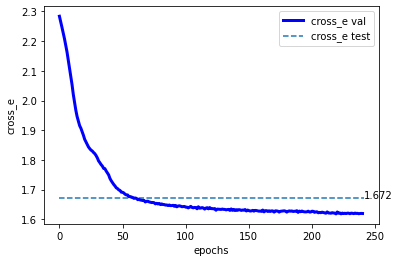

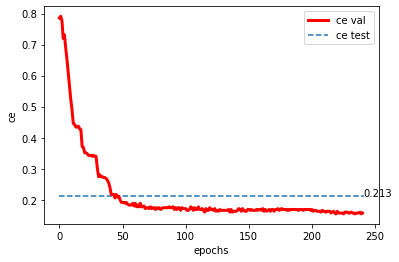

In [21]:
train_and_evaluate_full(hyperparameters=sample_hyperparameters, name='sample_cnn')

We see that our pipline works, and that we can use it 'partially' to quickly train many different custom CNNs, proposed by the genetic algorithm, and then perform a full training and evaluation procedure on the best performing proposed CNN architecture.


We note that this sample architecture gave a classification error of 0.213. Can we do better using neuroevolution? That is, can we, using a genetic/evolutionary algorithm to find an architecture which will surpass given sample architecture?

## Part 4 - Genetic Algorithm

### Part 4.1

In the final (and main) part of this assignment, we use a genetic algorithm to try and search for the best performing CNN architecture, i.e. the set of hyperparameters producing the best performing CNN on the test set.

In [22]:
import random

This is a reduced version of previous 'train_and_evaluate_full' function, with the goal to quickly train and validate a proposed CNN architecture and output its lowest classification error score. 

In [23]:
def train_and_evaluate(hyperparameters, num_epochs=10):
    
    lr = 1e-3 # learning rate
    wd = 1e-5 # weight decay
    
    # Init ClassifierNN
    classnet = CustomCNN(**hyperparameters).compile_cnn()
    model = ClassifierNeuralNet(classnet)

    
    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

   
    # Training procedure
    error_val = training(name=None,
                        num_epochs=num_epochs,
                        model=model,
                        optimizer=optimizer,
                        training_loader=training_loader,
                        val_loader=val_loader,
                        neuroevolution=True)
    return error_val

In [24]:
hyperparams_grid = {'num_filters':[8, 16, 32],
                'kernel_size':[3, 5],
                'activation_func':['relu', 'sigmoid', 'tanh', 'softplus', 'elu'],
                'pooling_type':['identity', 'avg', 'max'],
                'mlp_neurons_num':list(range(10, 101, 10))}

In this implementation of genetic algorithm, each 'individual' will represent some combination of hyperparameters from the  given grid. The 'population pool' will then consists of these sets of individuals. For every individual we will associate a 'cost' - value of the objective function on the validation set, from the CNN obtained by the parameters of the individual. This cost will determine the individual's survival rate - individuals producing CNNs with low objective function/classification error scores will have a higher chances to survive and stay in the population pool.

In [29]:
#function to generate the initial population pool, by randomly assigning hyperparameter values from the given grid
def generate_hyperparms():
    init_hyperparams = {}
    for key, value in hyperparams_grid.items():
        init_hyperparams[key] = random.choice(value)
    return init_hyperparams

In [25]:
#function that 'mutates' the individual, i.e. the hyperparameters set, by randomly selecting two hyperparameters and 
#randomly assigning new values to them
def mutate_hyperparams(hyperparams_dict):
    
    hyperpar1, hyperpar2 = random.sample(hyperparams_grid.keys(), k=2)
    hyperparams_dict[hyperpar1] = random.choice(hyperparams_grid[hyperpar1])
    hyperparams_dict[hyperpar2] = random.choice(hyperparams_grid[hyperpar2])

    return hyperparams_dict

In [26]:
#function that create two offspring individuals from to parent individuals, by copying one part of the hyperparameters
#from the first parent, and the rest form the second; and vice versa for the second offspring
def create_offsprings(parent1, parent2):
    offspring1 = {}
    offspring2 = {}
    
    for i, key in enumerate(hyperparams_grid.keys()):
        if i % 2 == 0:
            offspring1[key] = parent1[key]
            offspring2[key] = parent2[key]
        else:
            offspring1[key] = parent2[key]
            offspring2[key] = parent1[key]

    return offspring1, offspring2

In [31]:
#Now we finally propose a genetic algorithm for neuroevolution.
def gen_alg(start_population=4, max_iter=25, patience=5, mutation_prob=0.05):
    
    population_pool = []
    individual_costs = []
    current_patience = patience
    
    #First we (randomly) create an inital population pool, construct corresponding CNNs from then, and then quickly
    #train and validate them to obtain their cost score.
    print('Forming the initial population...')
    for _ in range(start_population):
        init_hyperparms = generate_hyperparms()
        population_pool.append(init_hyperparms)
        ind_cost = train_and_evaluate(hyperparameters=init_hyperparms)
        individual_costs.append(ind_cost)
        
    best_idx = np.argmin(individual_costs)
    best_configuration = population_pool[best_idx]
    lowest_obj_func_val = individual_costs[best_idx]
    print('Population number:', len(population_pool), 'Lowest obj_func_val:', lowest_obj_func_val)
    print('---------------------------------')
   
        
    i = 1
    while i <= max_iter:
        print('iter:', i)
        #we select two parents from the population at random, to produce two offsprings,
        #for which we also compute the cost score.
        parent1, parent2 = random.sample(population_pool, 2)
        offspring1, offspring2 = create_offsprings(parent1, parent2)
        population_pool += [offspring1, offspring2]
        offspring1_cost = train_and_evaluate(hyperparameters=offspring1)
        offspring2_cost = train_and_evaluate(hyperparameters=offspring2)
        individual_costs += [offspring1_cost, offspring2_cost]

        #we go through the whole population pool to see if some individual is going to mutate;
        #if this happens, we re-compute the cost score for this mutated individual
        for k, individual in enumerate(population_pool):
            if random.random() < mutation_prob:
                mutated_individual = mutate_hyperparams(individual)
                population_pool[k] = mutated_individual
                individual_costs[k] = train_and_evaluate(hyperparameters=mutated_individual)
                            
       
        if i < max_iter:
            #based on the cost score, we assign a survival rate to each individual
            #then we remove some individual from the population pool, where the individuals with high survival rates
            #i.e. low cost scores have greater chances to survive and stay in the population pool
            survival_rates = [1-ind_cost*.85 for ind_cost in individual_costs]
            deletion_idx = [k for k in range(len(survival_rates)) if survival_rates[k] < random.random()]
            population_pool = [individual for idx, individual in enumerate(population_pool) 
                               if idx not in deletion_idx]
            individual_costs = [cost for idx, cost in enumerate(individual_costs) 
                               if idx not in deletion_idx]
            
        best_idx = np.argmin(individual_costs)
        best_configuration = population_pool[best_idx]
        new_lowest_obj_func_val = individual_costs[best_idx]
        
        #we also introduce the patience - if after several generations/iterations no new individual 
        #with a lower cost score is produced, we stop the algorithm
        if new_lowest_obj_func_val < lowest_obj_func_val:
            lowest_obj_func_val = new_lowest_obj_func_val
            current_patience = patience
        else:
            current_patience -= 1
            print('current patience:', current_patience)
        
        print('Population number:', len(population_pool), 'Lowest obj_func_val:', lowest_obj_func_val)
        print('---------------------------------')
        if current_patience == 0:
            break
            
        new_individuals = []
        i += 1
    
    #from the final population pool we select the best individual, i.e. the set of hyperparameters producing CNN
    #that gives the best result on the validation set
    print('Best hyperparameter configuration:') 
    print(best_configuration)
    print('With the lowest objective function value:', lowest_obj_func_val)
    return best_configuration, lowest_obj_func_val

## Part 4.2

Now we run the genetic algorithm to try and search for (an approximation of) best possible configuration of hyperparameters. 

In [32]:
best_hyperparams, lowest_cost = gen_alg()

Forming the initial population...
Population number: 4 Lowest obj_func_val: 0.04860185987504094
---------------------------------
iter: 1
Population number: 5 Lowest obj_func_val: 0.03716957532991431
---------------------------------
iter: 2
current patience: 4
Population number: 7 Lowest obj_func_val: 0.03716957532991431
---------------------------------
iter: 3
current patience: 3
Population number: 8 Lowest obj_func_val: 0.03716957532991431
---------------------------------
iter: 4
current patience: 2
Population number: 8 Lowest obj_func_val: 0.03716957532991431
---------------------------------
iter: 5
current patience: 1
Population number: 9 Lowest obj_func_val: 0.03716957532991431
---------------------------------
iter: 6
Population number: 9 Lowest obj_func_val: 0.02010271186862301
---------------------------------
iter: 7
current patience: 4
Population number: 11 Lowest obj_func_val: 0.02010271186862301
---------------------------------
iter: 8
current patience: 3
Population nu

In [33]:
best_hyperparams, lowest_cost

({'num_filters': 32,
  'kernel_size': 3,
  'activation_func': 'relu',
  'pooling_type': 'identity',
  'mlp_neurons_num': 60},
 0.02010271186862301)

Now that we found a better performing CNN using the genetic algorithm, we will use the corresponding set of hyperparameters to fully train this CNN and evaluate it on the test set. 

Epoch: 0, val cross_e=1.7497049168178014, val ce=0.19714285714285715
Epoch: 10, val cross_e=1.5026964242117746, val ce=0.02857142857142857
Epoch: 20, val cross_e=1.49975827898298, val ce=0.02857142857142857
Epoch: 30, val cross_e=1.4979904283796037, val ce=0.037142857142857144
Epoch: 40, val cross_e=1.4966121455601284, val ce=0.03142857142857143
Epoch: 50, val cross_e=1.4963382611955915, val ce=0.02857142857142857
Epoch: 60, val cross_e=1.495395736694336, val ce=0.02857142857142857
Epoch: 70, val cross_e=1.4948741040910993, val ce=0.02857142857142857
Epoch: 80, val cross_e=1.4947745404924666, val ce=0.02857142857142857
Epoch: 90, val cross_e=1.4941260201590403, val ce=0.02857142857142857
Epoch: 100, val cross_e=1.4938012259347098, val ce=0.02857142857142857
Epoch: 110, val cross_e=1.4929813929966518, val ce=0.02857142857142857
Epoch: 120, val cross_e=1.4925990295410156, val ce=0.02857142857142857
Epoch: 130, val cross_e=1.4922860172816685, val ce=0.025714285714285714
Epoch: 140, val cr

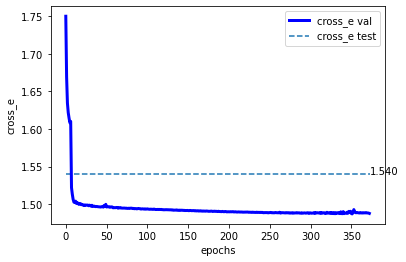

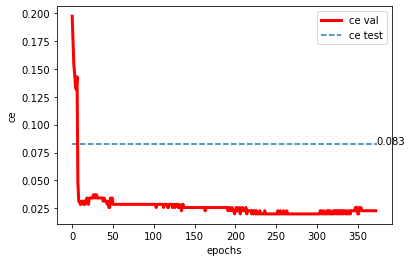

In [35]:
train_and_evaluate_full(hyperparameters=best_hyperparams, name='best_cnn')

If we recall, the classification error on the inital 'sample_cnn' was 0.213. The classification error on the configuration obtained by using a genetic algorithm, i.e. neuroevolution, is 0.083 which is a vast improvement. 